<a href="https://colab.research.google.com/github/wdogfish/ads_pub/blob/master/fbprophet_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fbprophet import Prophet

In [0]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# load in data 
dat = pd.read_excel('tfl-daily-cycle-hires.xls', sheet_name='Data')

# we are only interested in the first two columns
dat = dat[ [u'Day', u'Number of Bicycle Hires']]
dat.head()

,Day,Number of Bicycle Hires
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


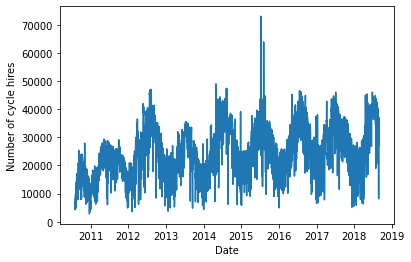

In [0]:
plt.plot( dat['Day'], dat['Number of Bicycle Hires'])
plt.xlabel('Date')
plt.ylabel('Number of cycle hires')
plt.show()

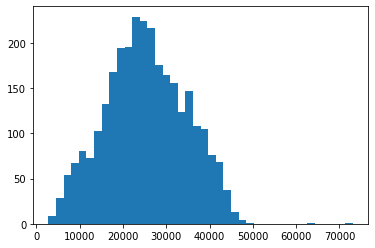

In [0]:
# Histrogram of the data to demonstrate there are large positive outliers.
# It is important to note that due to the seasonality, there may also be large 
# negative outliers, but we cannot spot them in the histogram below as 
# they are within the range of the data. 
#
# the data appears to be approximately Gaussian, with a few outliers (we discuss these below).
# so don't need to transform the data (e.g., via log transform)
plt.hist((dat['Number of Bicycle Hires']), bins=40)
plt.show()

In [0]:
# The prophet package expects input as a dataframe with the first column indicating time and 
# the second indicating the time series we wish to forecast

dat['Day'] = pd.DatetimeIndex( dat['Day'] )

# It also expects these columns to have the names 'ds' and 'y', so we rename them accordingly
dat = dat.rename(columns={'Day': 'ds', 'Number of Bicycle Hires': 'y'}) 
dat.head()

,ds,y
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


In [0]:
# Following our discussion, we add a set of outliers/holidays for our Prophet model.
# we make a separate DataFrame for bank holidays and for tube strikes

# We get the list of bank holidays from the following csv file:

bank_holidays = pd.DataFrame({
    'holiday': 'BankHoliday',
    'ds'     : pd.to_datetime( list(pd.read_csv('BankHolidayLists.csv')['Date']) )
})

strike_days = pd.DataFrame({
    'holiday': 'strike',
    'ds'     : pd.to_datetime( ['2017-08-05', '2017-08-06', '2017-02-06', '2015-07-09', '2015-07-08', '2015-03-08'] )
})


all_holidays_strikes = pd.concat( (bank_holidays, strike_days) )
all_holidays_strikes.tail(n=10)

,holiday,ds
92,BankHoliday,2020-05-25
93,BankHoliday,2020-08-31
94,BankHoliday,2020-12-25
95,BankHoliday,2020-12-28
0,strike,2017-08-05
1,strike,2017-08-06
2,strike,2017-02-06
3,strike,2015-07-09
4,strike,2015-07-08
5,strike,2015-03-08


In [0]:
# now we are ready to fit a forecast model with prophet
forecast_model = Prophet( growth='linear',  weekly_seasonality=3, yearly_seasonality=3, holidays=all_holidays_strikes )
forecast_model.fit( dat )

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


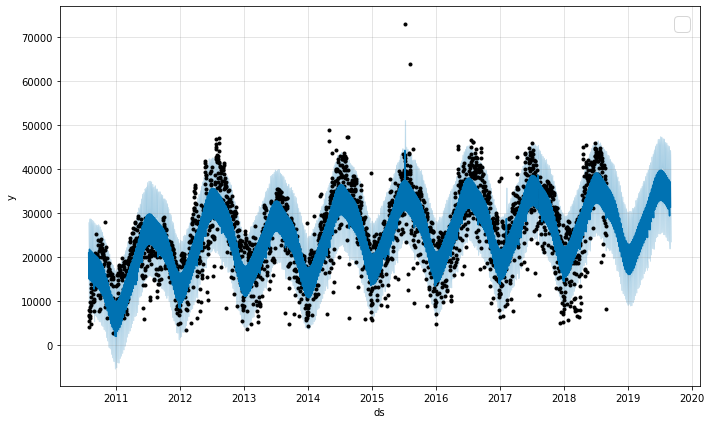

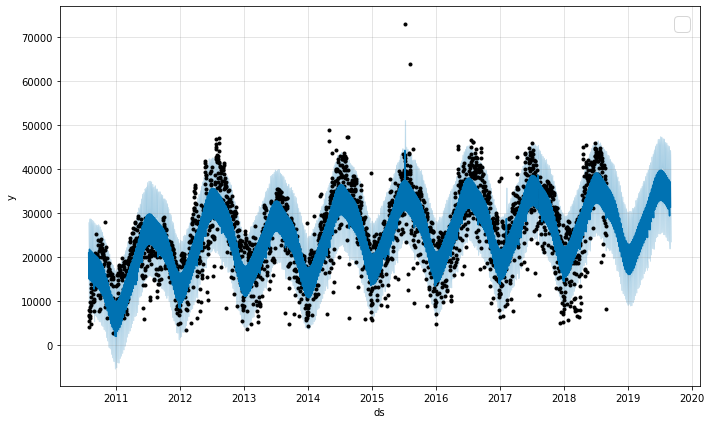

In [0]:
# we can now study the fit of the model - in order to do so, we need to creat another df
df_dates = forecast_model.make_future_dataframe(periods=365, 
                                                include_history=True)
model_predictions = forecast_model.predict( df_dates )
plot_pred = forecast_model.plot( model_predictions )
plt.legend(loc='best', fontsize=20)
plot_pred

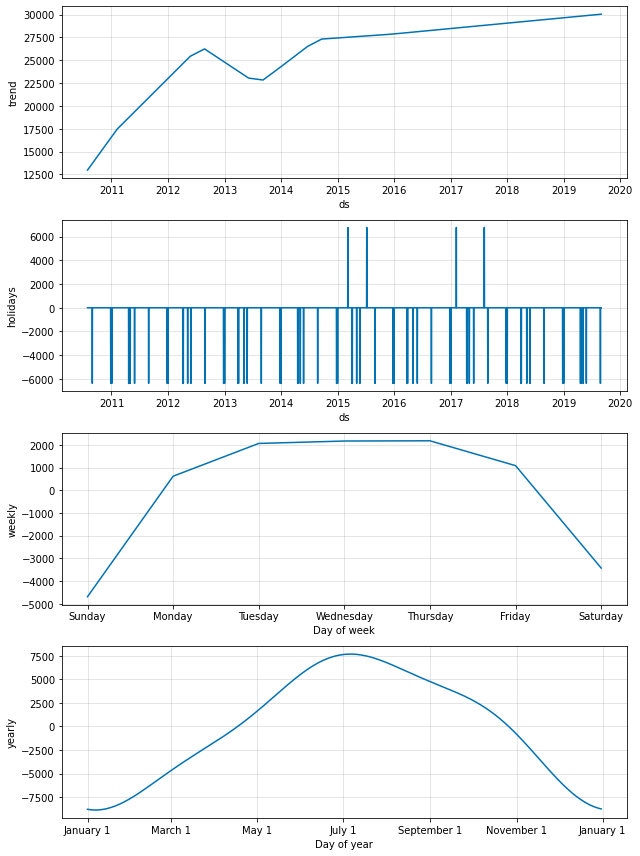

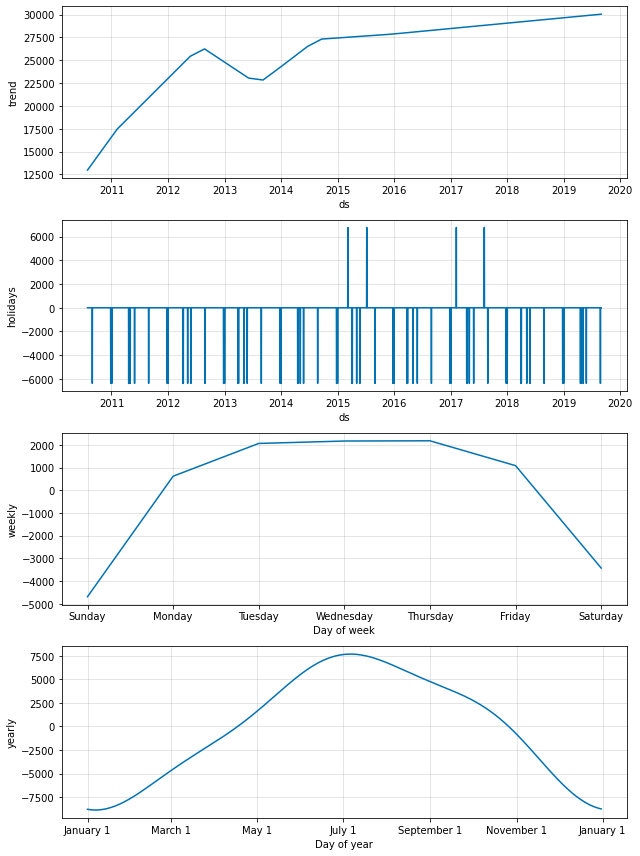

In [0]:
# we can also study the model components - this allows us to further understand the data we study
#
# we notice the following:
# initial trend during 2011-2013 which levels off (there appears to be a dip in summer of 2013, its unclear why)
# clear yearly seasonlity with a peak in the summer and drop in winter
# also a clear weekly seasonality - it seems the bikes are used mostly during the week (presumably for commuting) than on weekends
# Finally, we note that bank holidays lead to a fall in the usage of the bikes, while the days of the strikes lead to significant increases!

forecast_model.plot_components( forecast_model.predict(df_dates), 
                               uncertainty=False )